<a href="https://colab.research.google.com/github/avokhuese/TSdataaugmentation/blob/main/Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import warnings
from tensorflow.keras.utils import get_file
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, median_absolute_error
import numpy as np

In [ ]:
# Performance Metric
def metric(original, augmented):
    MSE = mean_squared_error(original, augmented)
    MAE = mean_absolute_error(original, augmented)
    MedAE = median_absolute_error(original, augmented)
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((original - augmented) / original)) * 100

    return [MSE, MAE, MedAE, RMSE, MAPE]


In [ ]:
def jitter_series(series, noise_level=0.02):
    return series + noise_level * np.random.randn(len(series))

In [ ]:
def magnitude_warp_time_series(data, column_name, scaling_factor):
    warped_data = data.copy()
    warped_data[column_name] = data[column_name] * scaling_factor
    return warped_data


In [ ]:
def permute_time_series(data, column_name):
    permuted_data = data.copy()
    permuted_data[column_name] = np.random.permutation(permuted_data[column_name])
    return permuted_data

In [ ]:
def rotate_time_series(data, column_name, num_steps):
    """
    Rotate a time series data by a specified number of steps.

    Parameters:
    - data (pd.DataFrame): The input time series data.
    - column_name (str): The name of the column to rotate.
    - num_steps (int): The number of steps to rotate the data. Positive values shift the data forward, negative values shift it backward.

    Returns:
    - pd.DataFrame: The rotated time series data.
    """
    rotated_data = data.copy()
    rotated_data[column_name] = data[column_name].shift(periods=num_steps)
    rotated_data.fillna(rotated_data[column_name].mean(),inplace=True)
    return rotated_data


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def scale_time_series(data, column, Scaler):
    scaled_data=data.copy()
    # Reshape the data to be 2D (required by sklearn scalers)
    reshaped_data = data[column].values.reshape(-1, 1)

    # Instantiate the scaler
    scaler = Scaler


    # Fit and transform the data
    scaled_data_ = scaler.fit_transform(reshaped_data)

    # Return the scaled data as a DataFrame or Series
    scaled_data[column] = scaled_data_
    return scaled_data


In [ ]:
def slice_time_series(data, column_name, window_size, step_size):

    sliced_data = []
    column = data[column_name]
    for i in range(0, len(column) - window_size + 1, step_size):
        window = column[i:i + window_size]
        sliced_data.append(window.values)

    sliced_data = pd.DataFrame(sliced_data, columns=[f"{column_name}_window_{i}" for i in range(window_size)])

    return sliced_data

In [ ]:
def time_warp(series, sampling_rate=0.1):
    time_indices = np.arange(len(series))
    warp_indices = np.random.uniform(0, 1, size=len(series)) * sampling_rate
    warped_series = np.interp(time_indices + warp_indices, time_indices, series)
    return warped_series

In [ ]:
def time_slice_series(series, slice_size=50):
    start = np.random.randint(0, len(series) - slice_size)
    return series[start:start + slice_size]

In [ ]:
# Get bitcoin data
data=  yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2024-08-31').reset_index()
data.head(2)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-09 00:00:00+00:00,1.01087,1.01327,0.996515,1.00818,358188000,0.0,0.0
1,2017-11-10 00:00:00+00:00,1.00650,1.02423,0.995486,1.00601,756446016,0.0,0.0


## **STAGE 1**

Multi-Layered Jittering Augmentation

In [ ]:
def jitter_augmentation(data, column, noise_level, layers):

  score_dict={}
  original_series=data[column]
  series=data[column]

  for i in range(1,layers+1):

    name="jitter_layer_"+str(i)
    print(name)
    series=jitter_series(series, noise_level)
    series.to_csv(name+".csv", index=False)
    score=metric(original_series, series)
    score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index( ["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

Mag W Augmentation

In [ ]:
def magw_augmentation(data, column, scaling_factor, layers):

  score_dict={}
  original_series=data[column]

  for i in range(1,layers+1):

    name="magw_layer_"+str(i)
    print(name)
    series=magnitude_warp_time_series(data, column, scaling_factor)
    data=series.copy()
    series=series[column]
    series.to_csv(name+".csv", index=False)
    score=metric(original_series, series)
    score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index( ["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

Permuatation

In [ ]:
def permutation_augmentation(data, column, layers):

  score_dict={}
  original_series=data[column]

  for i in range(1,layers+1):

    name="permutate_layer_"+str(i)
    print(name)
    series=permute_time_series(data, column)
    data=series.copy()
    series=series[column]
    series.to_csv(name+".csv", index=False)

    score=metric(original_series, series)
    score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

Rotation Augmentation

In [ ]:
def rotation_augmentation(data, column, steps, layers):

  score_dict={}
  original_series=data[column]

  for i in range(1,layers+1):

    name="rotation_layer_"+str(i)
    print(name)
    series=rotate_time_series(data, column, steps)
    data=series.copy()
    series=series[column]
    series.to_csv(name+".csv", index=False)
    score=metric(original_series, series)
    score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index( ["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

**Scaler Augmentation**

In [ ]:
def scaler_augmentation(data, column,Scaler, layers):

  score_dict={}
  original_series=data[column]

  for i in range(1,layers+1):

    name="scaler_layer_"+str(i)
    print(name)
    series=scale_time_series(data, column, Scaler)
    data=series.copy()
    series=series[column]
    series.to_csv(name+".csv", index=False)
    score=metric(original_series, series)
    score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

Window Warping

In [ ]:
def winw_augmentation(data, column, step, layers, WINDOW_SIZE):

  score_dict={}
  original_series=data[column]

  for i in range(1,layers+1):
      name="Winw_layer_"+str(i)
      print(name)
      series=slice_time_series(data, column, WINDOW_SIZE, step)
      data=series.copy()
      column=column+"_window_"+str(WINDOW_SIZE-1)
      series=series[column]
      series.to_csv(name+".csv", index=False)
      original_series = original_series.iloc[: len(series)]
      score=metric(original_series, series)
      score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

Time Warping

In [ ]:
def timewarp_augmentation(data, column, sampling_rate, layers):

  score_dict={}
  original_series=data[column]
  series = data[column]

  for i in range(1,layers+1):

    name="timewarp_layer_"+str(i)
    print(name)
    series=time_warp(series, sampling_rate)
    pd.Series(series).to_csv(name+".csv", index=False)
    score=metric(original_series, series)
    score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

Time Slicing

In [ ]:
def time_slice_augmentation(data, column, slice_size, layers):

  score_dict={}
  original_series=data[column]
  series = data[column]

  for i in range(1,layers+1):
    try:
      name="timeslice_layer_"+str(i)
      print(name)
      slice_size = slice_size -10
      series=time_slice_series(series, slice_size)
      series.to_csv(name+".csv", index=False)
      original_series = original_series.iloc[: len(series)]
      score=metric(original_series, series)
      score_dict[name]= score
    except:
      break
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

## **STAGE 2**

In [ ]:
def augmentation_selection(data, column, layers, rotation_steps, magw_scaling_factor, jitter_noise_level,\
                           Scaler, winw_window_size, winw_step, timwarp_sampling_rate, time_slice_size):

  results = pd.DataFrame()

  result=jitter_augmentation(data, column, jitter_noise_level, layers)
  results=pd.concat([results, result], axis=1)

  result=magw_augmentation(data, column, magw_scaling_factor, layers)
  results=pd.concat([results, result], axis=1)

  result=permutation_augmentation(data, column, layers)
  results=pd.concat([results, result],axis=1)

  result=rotation_augmentation(data, column, rotation_steps, layers)
  results=pd.concat([results, result], axis=1)

  result=scaler_augmentation(data, column, Scaler, layers)
  results=pd.concat([results, result], axis=1)

  result=winw_augmentation(data, column, winw_step, layers, winw_window_size)
  results=pd.concat([results, result], axis=1)

  result=timewarp_augmentation(data, column, timwarp_sampling_rate, layers)
  results=pd.concat([results, result], axis=1)

  result=time_slice_augmentation(data, column, time_slice_size, layers)
  results=pd.concat([results, result], axis=1)


  # Find the column names with the highest RMSE, MSE, and MAE

  lowest_mse_col = results.loc['MSE'].idxmin()
  lowest_mse_score = results.loc['MSE'].min()

  lowest_mae_col = results.loc['MAE'].idxmin()
  lowest_mae_score = results.loc['MAE'].min()

  lowest_mape_col = results.loc['MAPE'].idxmin()
  lowest_mape_score = results.loc['MAPE'].min()

  lowest_rmse_col = results.loc['RMSE'].idxmin()
  lowest_rmse_score = results.loc['RMSE'].min()

  lowest_medae_col = results.loc['MedAE'].idxmin()
  lowest_medae_score = results.loc['MedAE'].min()

  # Print the results
  print(f"Lowest MSE: {lowest_mse_col} with score {lowest_mse_score}")
  print(f"Lowest MAE: {lowest_mae_col} with score {lowest_mae_score}")
  print(f"Lowest MAPE: {lowest_mape_col} with score {lowest_mape_score}")
  print(f"Lowest RMSE: {lowest_rmse_col} with score {lowest_rmse_score}")
  print(f"Lowest MedAE: {lowest_medae_col} with score {lowest_medae_score}")


  return results, [lowest_mse_col, lowest_mae_col]



## **STAGE 3**

In [ ]:
def magw_augmentation_(data, column, scaling_factors, layers):

  score_dict={}
  data_=data
  column_=column

  for scaling_factor in scaling_factors:
    data= data_
    column= column_
    original_series=data[column]
    for i in range(1,layers+1):
      name="magw_layer_"+str(i)+"_scaling_factor_"+str(scaling_factor)
      print(name)
      series=magnitude_warp_time_series(data, column, scaling_factor)
      data=series.copy()
      series=series[column]
      series.to_csv(name+".csv", index=False)
      score=metric(original_series, series)
      score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores


In [ ]:
def rotation_augmentation_(data, column, steps, layers):

  score_dict={}
  data_=data
  column_=column

  for step in steps:
    data= data_
    column= column_
    original_series=data[column]
    for i in range(1,layers+1):

      name="rotation_layer_"+str(i)+"_step_"+str(step)
      print(name)
      series=rotate_time_series(data, column, step)
      data=series.copy()
      series=series[column]
      series.to_csv(name+".csv", index=False)
      score=metric(original_series, series)
      score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

In [ ]:
def jitter_augmentation_(data, column, noise_level, layers):

  score_dict={}
  data_=data
  column_=column

  for noise in noise_level:
    data= data_
    column= column_
    series=data[column]
    original_series=data[column]
    for i in range(1,layers+1):

      name="jitter_layer_"+str(i)+"_noise_"+str(noise)
      print(name)
      series=jitter_series(series, noise)
      series.to_csv(name+".csv", index=False)
      score=metric(original_series, series)
      score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores


In [ ]:
def scaler_augmentation_(data, column,Scalers, layers):

  score_dict={}
  data_=data
  column_=column

  for num,Scaler in enumerate(Scalers):
    data= data_
    column= column_
    original_series=data[column]
    for i in range(1,layers+1):

      name="scaler_layer_"+str(i)+"_scaler_"+str(num)
      print(name)
      series=scale_time_series(data, column, Scaler)
      data=series.copy()
      series=series[column]
      series.to_csv(name+".csv", index=False)
      score=metric(original_series, series)
      score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index(["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

In [ ]:
def winw_augmentation_(data, column, steps, layers, WINDOW_SIZE):

  score_dict={}
  data_=data
  column_=column

  for step in steps:
    data= data_
    column= column_
    original_series=data[column]
    for i in range(1,layers+1):
        try:
          name= "winw_layer_"+str(i)+"_step_"+str(step)
          print(name)
          series=slice_time_series(data, column, WINDOW_SIZE, step)
          data=series.copy()
          column=column+"_window_"+str(WINDOW_SIZE-1)
          series=series[column]
          series.to_csv(name+".csv", index=False)
          original_series_ = original_series.iloc[: len(series)]
          score=metric(original_series_, series)
          score_dict[name]= score
          print(column)
        except:
          break
  scores=pd.DataFrame(score_dict).set_index(pd.Index( ["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

In [ ]:
def timewarp_augmentation_(data, column, sampling_rates, layers):

  score_dict={}
  data_=data
  column_=column

  for sampling_rate in sampling_rates:
    data= data_
    column= column_
    series = data[column]
    original_series=data[column]
    for i in range(1,layers+1):
      name="timewarp_layer_"+str(i) +"_sampling_rate_"+str(sampling_rate)
      print(name)
      series=time_warp(series, sampling_rate)
      pd.Series(series).to_csv(name+".csv", index=False)
      score=metric(original_series, series)
      score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index( ["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

In [ ]:
def time_slice_augmentation_(data, column, slice_sizes, layers):

  score_dict={}
  data_=data
  column_=column

  for slice_size in slice_sizes:

    data= data_
    column= column_
    original_series=data[column]
    series = data[column]

    for i in range(1,layers+1):
        try:
          name="timeslice_layer_"+str(i) +"_slice_size_"+str(slice_size)
          print(name)
          slice_size = slice_size -10
          series=time_slice_series(series, slice_size)
          series.to_csv(name+".csv", index=False)
          original_series_ = original_series.iloc[: len(series)]
          score=metric(original_series_, series)
          score_dict[name]= score
        except:
          break

  scores=pd.DataFrame(score_dict).set_index(pd.Index( ["MSE", "MAE","MedAE", "RMSE", "MAPE"]))
  return scores

In [ ]:
def augementation_optimization(data, column, best_augmentation, magw_factors, rotation_steps, jitter_noises, winw_steps, winw_window_size, \
                               timwarp_sampling_rates, time_slice_sizes):

  opt_layer=best_augmentation[1].split('_')[2]
  opt_layer=int(opt_layer)

  if "magw_layer" in best_augmentation[1]:
    result=magw_augmentation_(data, column, magw_factors, opt_layer)
  elif "rotation_layer" in best_augmentation[1]:
    result=rotation_augmentation_(data, column, rotation_steps, opt_layer)
  elif "jitter_layer" in best_augmentation[1]:
    result=jitter_augmentation_(data, column, jitter_noises, opt_layer)
  elif "scaler_layer" in best_augmentation[1]:
    result=scaler_augmentation_(data, column, [MinMaxScaler(),StandardScaler(), RobustScaler()], opt_layer)
  elif "permutate_layer" in best_augmentation[1]:
    result=permutation_augmentation(data, column, opt_layer)
  elif "winw_layer" in best_augmentation[1]:
    result=winw_augmentation_(data, column, winw_steps, opt_layer,  winw_window_size)
  elif "timewarp_layer" in best_augmentation[1]:
    result=timewarp_augmentation_(data, column, timwarp_sampling_rates, opt_layer)
  elif "timeslice_layer" in best_augmentation[1]:
    result=time_slice_augmentation_(data, column, time_slice_sizes, opt_layer)


## **Running the algorithm**

In [ ]:
def plots (data, column, paths, num):
  df=data[column]
  for i in paths:
    df_=pd.read_csv(i)
    col=i.split("/")[-1].split('.')[0]
    df_.columns=[col]
    df=pd.concat([df, df_], axis=1)

  df=df.head(num)
  df.plot(kind="line", figsize=(15,8))

**Climate Data**

In [ ]:
# Download and load the dataset
zip_path = get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

csv_path, _ = os.path.splitext(zip_path)

data = pd.read_csv(csv_path)

column= "T (degC)"
magw_scaling_factors = [1.03,1.04]
rotation_steps = [1,2]
jitter_noises = [0.01,0.02]
winw_steps= [1,2]
timwarp_sampling_rates= [0.1, 0.2]
time_slice_sizes =[2000, 1500]

print("Running Multiple layered Augmentation")
results, best_=augmentation_selection(data, column= column, layers=3,rotation_steps= 1, magw_scaling_factor=1.03,  \
                                      jitter_noise_level=0.02, Scaler=MinMaxScaler(), winw_window_size = 5, winw_step=1, \
                                      timwarp_sampling_rate=10, time_slice_size=2000)


print("\nOptimizing Augmentation")
augementation_optimization(data, column=column, best_augmentation = best_, magw_factors = magw_scaling_factors, rotation_steps = rotation_steps, \
                           jitter_noises= jitter_noises, winw_steps= winw_steps, winw_window_size=5, \
                               timwarp_sampling_rates = timwarp_sampling_rates, time_slice_sizes = time_slice_sizes)



13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Multiple layered Augmentation
jitter_layer_1
jitter_layer_2
jitter_layer_3
magw_layer_1
magw_layer_2
magw_layer_3
permutate_layer_1
permutate_layer_2
permutate_layer_3
rotation_layer_1
rotation_layer_2
rotation_layer_3
scaler_layer_1
scaler_layer_2
scaler_layer_3
Winw_layer_1
Winw_layer_2
Winw_layer_3
timewarp_layer_1
timewarp_layer_2
timewarp_layer_3
timeslice_layer_1
timeslice_layer_2
timeslice_layer_3
Lowest MSE: jitter_layer_1 with score 0.0004011566182585437
Lowest MAE: jitter_layer_1 with score 0.01598759568947753
Lowest MAPE: magw_layer_1 with score 3.000000000000002
Lowest RMSE: jitter_layer_1 with score 0.020028894584038923
Lowest MedAE: jitter_layer_1 with score 0.013524566408985805

Optimizing Augmentation
jitter_layer_1_noise_0.01
jitter_layer_1_noise_0.02


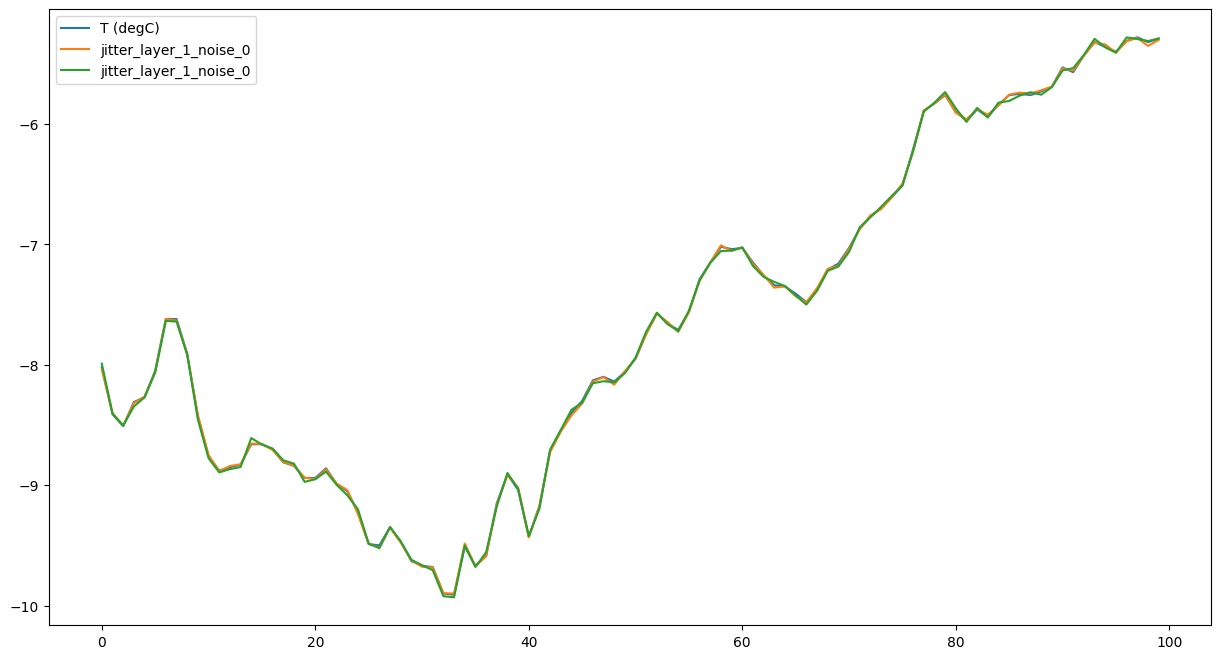

In [ ]:
paths = ["/content/jitter_layer_1_noise_0.01.csv", "/content/jitter_layer_1_noise_0.02.csv"]
plots(data, "T (degC)", paths, 100)

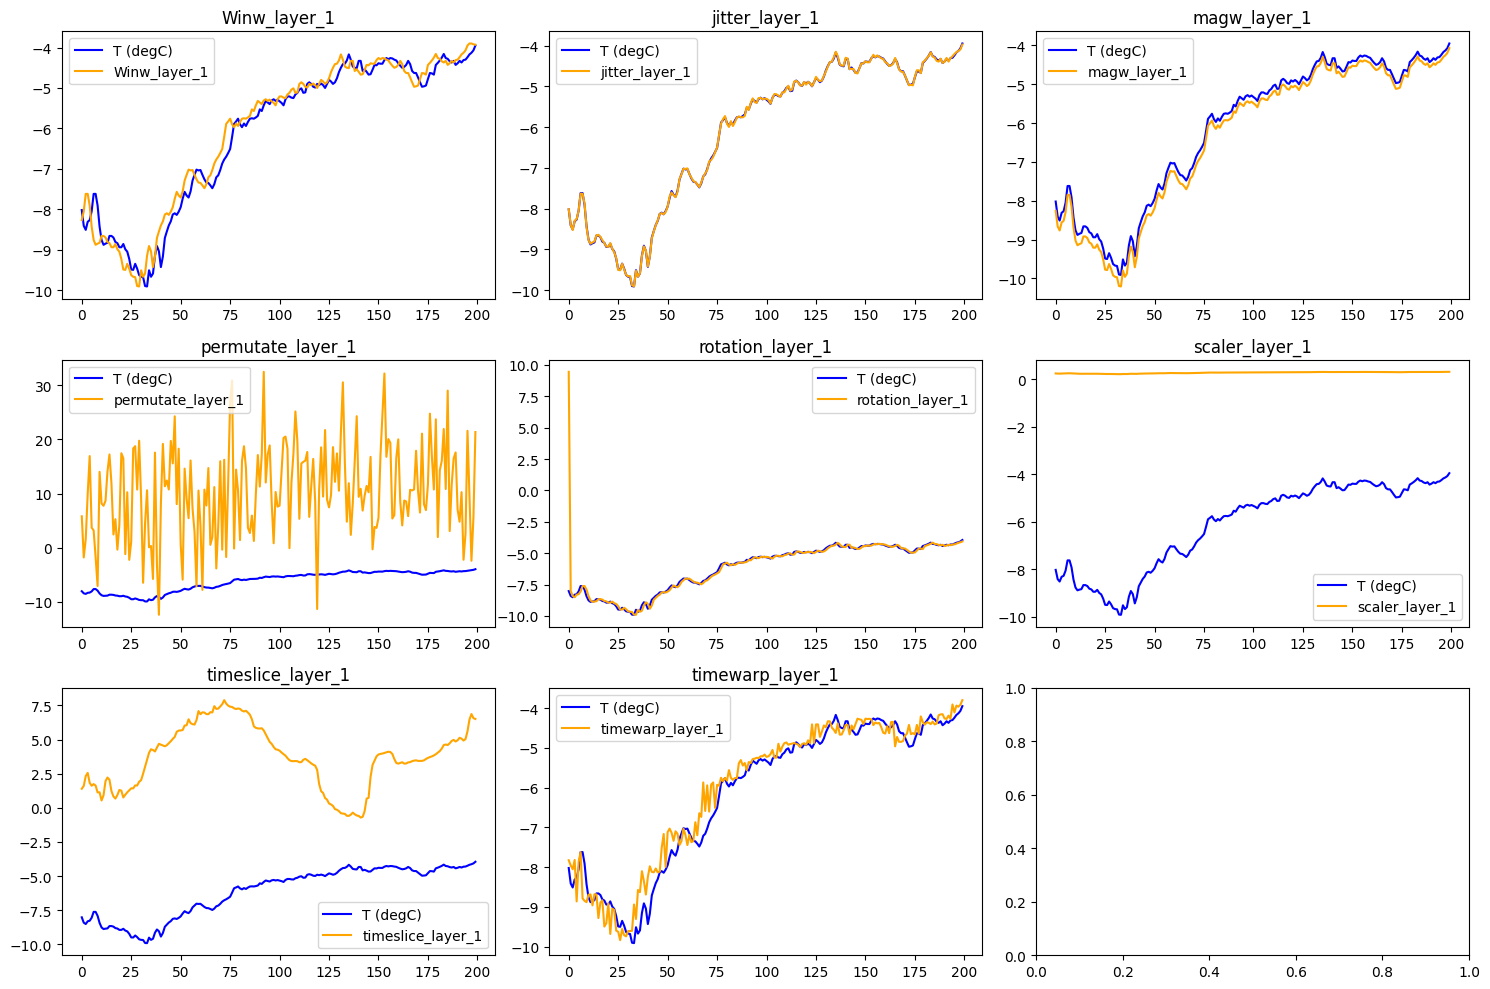

In [ ]:
paths=["/content/Winw_layer_1.csv", "/content/jitter_layer_1.csv", "/content/magw_layer_1.csv", "/content/permutate_layer_1.csv",\
 "/content/rotation_layer_1.csv", "/content/scaler_layer_1.csv", "/content/timeslice_layer_1.csv", "/content/timewarp_layer_1.csv" ]

df=data[column]
for i in paths:
  df_=pd.read_csv(i)
  col=i.split("/")[-1].split('.')[0]
  df_.columns=[col]
  df=pd.concat([df, df_], axis=1)

df=df.head(200)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each column as a subplot
for i, col in enumerate(df.columns[1:]):
    axes[i].plot(df[column], label=column, color='blue')
    axes[i].plot(df[col], label=col, color='orange')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

**Yahoo finance**

In [ ]:
data=yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2024-08-31').reset_index()

column= "Close"

magw_scaling_factors = [1.03,1.04]
rotation_steps = [1,2]
jitter_noises = [0.01,0.02]
winw_steps= [1,2]
timwarp_sampling_rates= [0.1, 0.2]
time_slice_sizes =[2000, 1500]

print("Running Multiple layered Augmentation")
results, best_=augmentation_selection(data, column= column, layers=3,rotation_steps= 1, magw_scaling_factor=1.03,  \
                                      jitter_noise_level=5, Scaler=MinMaxScaler(), winw_window_size = 5, winw_step=1, \
                                      timwarp_sampling_rate=19, time_slice_size=2000)


print("\nOptimizing Augmentation")
augementation_optimization(data, column=column, best_augmentation = best_, magw_factors = magw_scaling_factors, rotation_steps = rotation_steps, \
                           jitter_noises= jitter_noises, winw_steps= winw_steps, winw_window_size=5, \
                               timwarp_sampling_rates = timwarp_sampling_rates, time_slice_sizes = time_slice_sizes)

Running Multiple layered Augmentation
jitter_layer_1
jitter_layer_2
jitter_layer_3
magw_layer_1
magw_layer_2
magw_layer_3
permutate_layer_1
permutate_layer_2
permutate_layer_3
rotation_layer_1
rotation_layer_2
rotation_layer_3
scaler_layer_1
scaler_layer_2
scaler_layer_3
Winw_layer_1
Winw_layer_2
Winw_layer_3
timewarp_layer_1
timewarp_layer_2
timewarp_layer_3
timeslice_layer_1
timeslice_layer_2
timeslice_layer_3
Lowest MSE: rotation_layer_1 with score 1.564591300397357e-05
Lowest MAE: rotation_layer_1 with score 0.0016825864912641758
Lowest MAPE: timeslice_layer_1 with score 0.0
Lowest RMSE: rotation_layer_1 with score 0.00395549149967151
Lowest MedAE: rotation_layer_1 with score 0.000444948673248291

Optimizing Augmentation
rotation_layer_1_step_1
rotation_layer_1_step_2


In [ ]:
results

,jitter_layer_1,jitter_layer_2,jitter_layer_3,magw_layer_1,magw_layer_2,magw_layer_3,permutate_layer_1,permutate_layer_2,permutate_layer_3,rotation_layer_1,...,scaler_layer_3,Winw_layer_1,Winw_layer_2,Winw_layer_3,timewarp_layer_1,timewarp_layer_2,timewarp_layer_3,timeslice_layer_1,timeslice_layer_2,timeslice_layer_3
MSE,25.058910,52.769831,78.495416,0.000902,0.003718,0.008620,0.000049,0.000050,0.000051,0.000016,...,0.478137,0.000022,0.000027,0.000029,0.000024,0.000028,0.000031,0.000048,0.000046,0.000046
MAE,4.005707,5.773215,7.059177,0.030037,0.060975,0.092841,0.003836,0.003878,0.003951,0.001683,...,0.690314,0.002064,0.002332,0.002459,0.002151,0.002472,0.002581,0.003625,0.003581,0.003598
MedAE,3.449532,4.787400,5.871341,0.030009,0.060919,0.092756,0.001675,0.001637,0.001693,0.000445,...,0.697648,0.000558,0.000690,0.000728,0.000603,0.000720,0.000738,0.001187,0.001277,0.001285
RMSE,5.005887,7.264285,8.859764,0.030037,0.060976,0.092842,0.007010,0.007074,0.007137,0.003955,...,0.691474,0.004730,0.005203,0.005360,0.004874,0.005259,0.005554,0.006916,0.006765,0.006782
MAPE,400.069947,576.624953,705.074164,3.000000,6.090000,9.272700,0.382218,0.386437,0.393743,0.167457,...,68.968141,0.205506,0.232449,0.245059,0.214274,0.246429,0.257355,0.000000,0.000000,0.000000


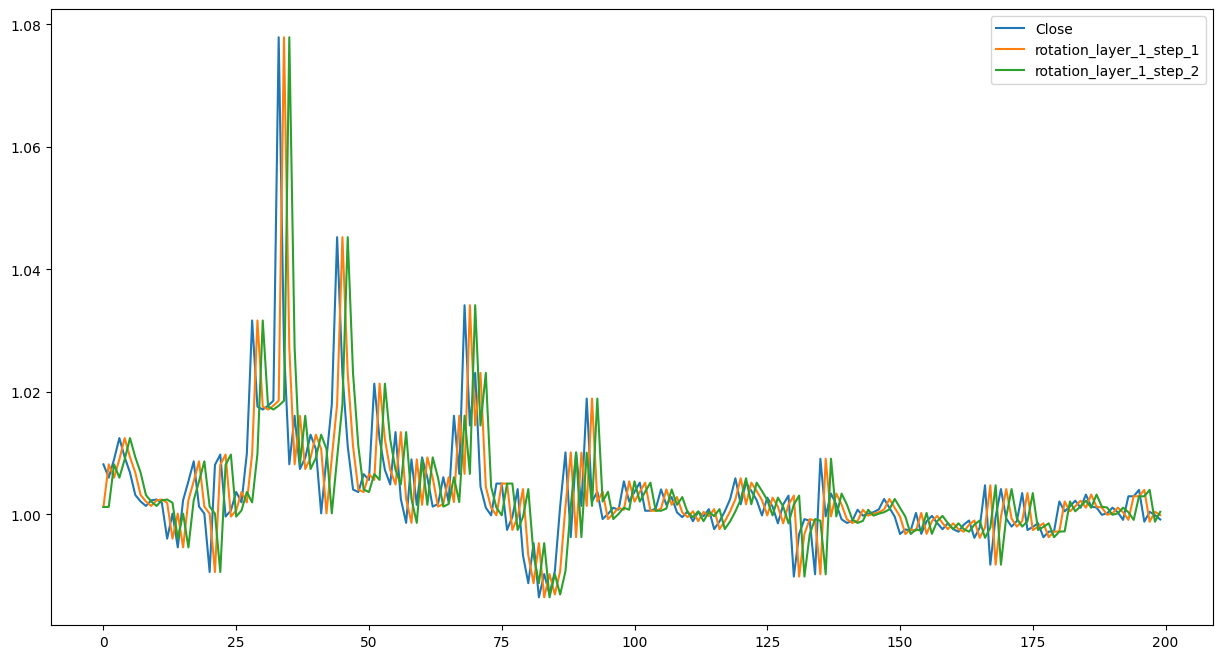

In [ ]:
paths = ["/content/rotation_layer_1_step_1.csv", "/content/rotation_layer_1_step_2.csv"]
plots(data, "Close", paths, 200)

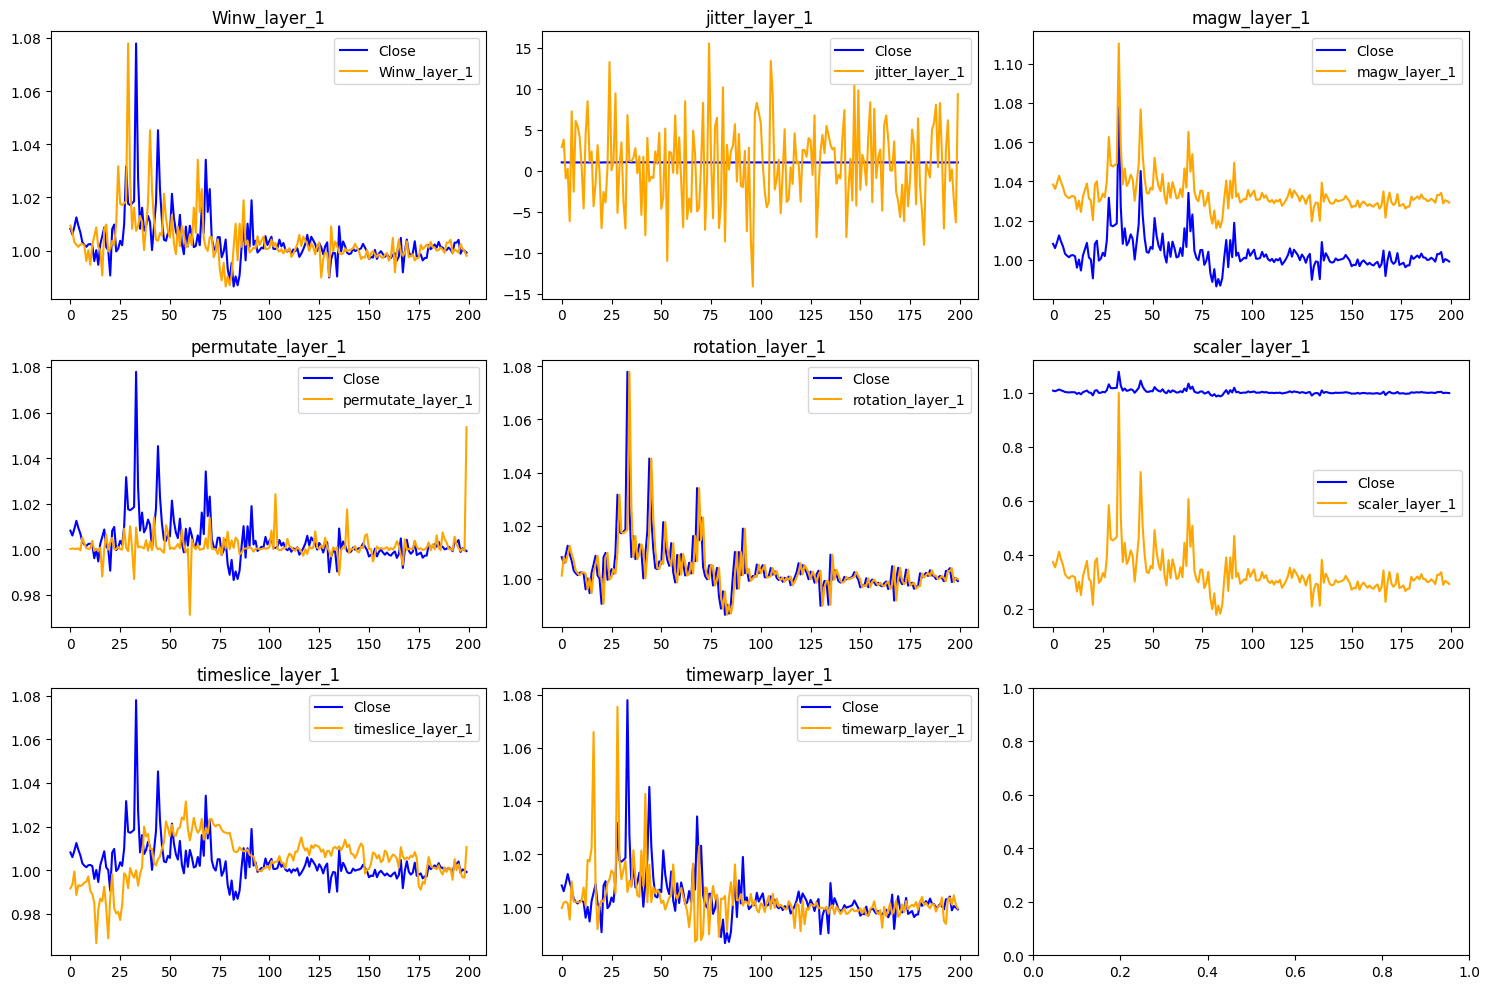

In [ ]:
paths=["/content/Winw_layer_1.csv", "/content/jitter_layer_1.csv", "/content/magw_layer_1.csv", "/content/permutate_layer_1.csv",\
 "/content/rotation_layer_1.csv", "/content/scaler_layer_1.csv", "/content/timeslice_layer_1.csv", "/content/timewarp_layer_1.csv" ]

df=data[column]
for i in paths:
  df_=pd.read_csv(i)
  col=i.split("/")[-1].split('.')[0]
  df_.columns=[col]
  df=pd.concat([df, df_], axis=1)

df=df.head(200)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each column as a subplot
for i, col in enumerate(df.columns[1:]):
    axes[i].plot(df['Close'], label='Close', color='blue')
    axes[i].plot(df[col], label=col, color='orange')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

# **STAGE 4 - Our Apporach**

In [ ]:
def jitter_and_rotate_time_series(data, column_name, num_steps, noise_level=0.02):
    """
    Apply jitter and rotate a time series data by a specified number of steps.

    Parameters:
    - data (pd.DataFrame): The input time series data.
    - column_name (str): The name of the column to process.
    - num_steps (int): The number of steps to rotate the data. Positive values shift the data forward, negative values shift it backward.
    - noise_level (float): The level of noise to add for jittering.

    Returns:
    - pd.DataFrame: The processed time series data with jitter and rotation applied.
    """
    processed_data = data.copy()

    # Apply jitter
    processed_data[column_name] = processed_data[column_name] + noise_level * np.random.randn(len(processed_data))

    # Rotate time series
    processed_data[column_name] = processed_data[column_name].shift(periods=num_steps)
    processed_data.fillna(processed_data[column_name].mean(), inplace=True)

    return processed_data


In [ ]:
def jitter_and_rotate_augmentation(data, column_name, num_steps, noise_level, layers):

  score_dict={}
  original_series=data[column_name]

  for i in range(1,layers+1):

    name="jitter_and_rotate_layer_"+str(i)
    print(name)
    series=jitter_and_rotate_time_series(data, column_name, num_steps, noise_level)
    data=series.copy()
    series=series[column]
    series.to_csv(name+".csv", index=False)
    score=metric(original_series, series)
    score_dict[name]= score
  scores=pd.DataFrame(score_dict).set_index(pd.Index( ["MSE", "MAE", "MedAE", "RMSE", "MAPE"]))
  return scores

In [ ]:
data= yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2024-08-31').reset_index()
column_name= "Close"
new_data=jitter_and_rotate_time_series(data, column_name, 1, noise_level=0.004)

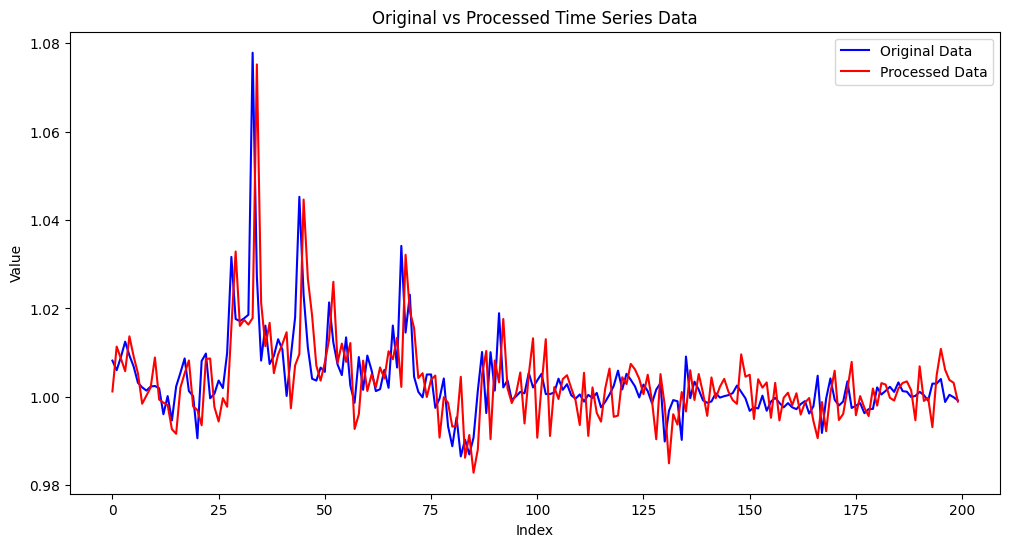

In [ ]:
# Assuming 'data' is your original DataFrame and 'new_data' is the processed DataFrame
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(data[column_name].head(200), label='Original Data', color='blue')

# Plot the processed data
plt.plot(new_data[column_name].head(200), label='Processed Data', color='red')

# Adding titles and labels
plt.title('Original vs Processed Time Series Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()


In [ ]:
jitter_and_rotate_augmentation(data, column, 1, noise_level=0.004,layers=7)

jitter_and_rotate_layer_1
jitter_and_rotate_layer_2
jitter_and_rotate_layer_3
jitter_and_rotate_layer_4
jitter_and_rotate_layer_5
jitter_and_rotate_layer_6
jitter_and_rotate_layer_7


,jitter_and_rotate_layer_1,jitter_and_rotate_layer_2,jitter_and_rotate_layer_3,jitter_and_rotate_layer_4,jitter_and_rotate_layer_5,jitter_and_rotate_layer_6,jitter_and_rotate_layer_7
MSE,0.000032,0.000052,0.000071,0.000089,0.000105,0.000126,0.000145
MAE,0.003992,0.005332,0.006320,0.007104,0.007828,0.008683,0.009441
MedAE,0.003107,0.004292,0.005173,0.005702,0.006550,0.007239,0.007964
RMSE,0.005664,0.007198,0.008429,0.009437,0.010244,0.011227,0.012059
MAPE,0.398283,0.532164,0.630811,0.709156,0.781635,0.866887,0.942522


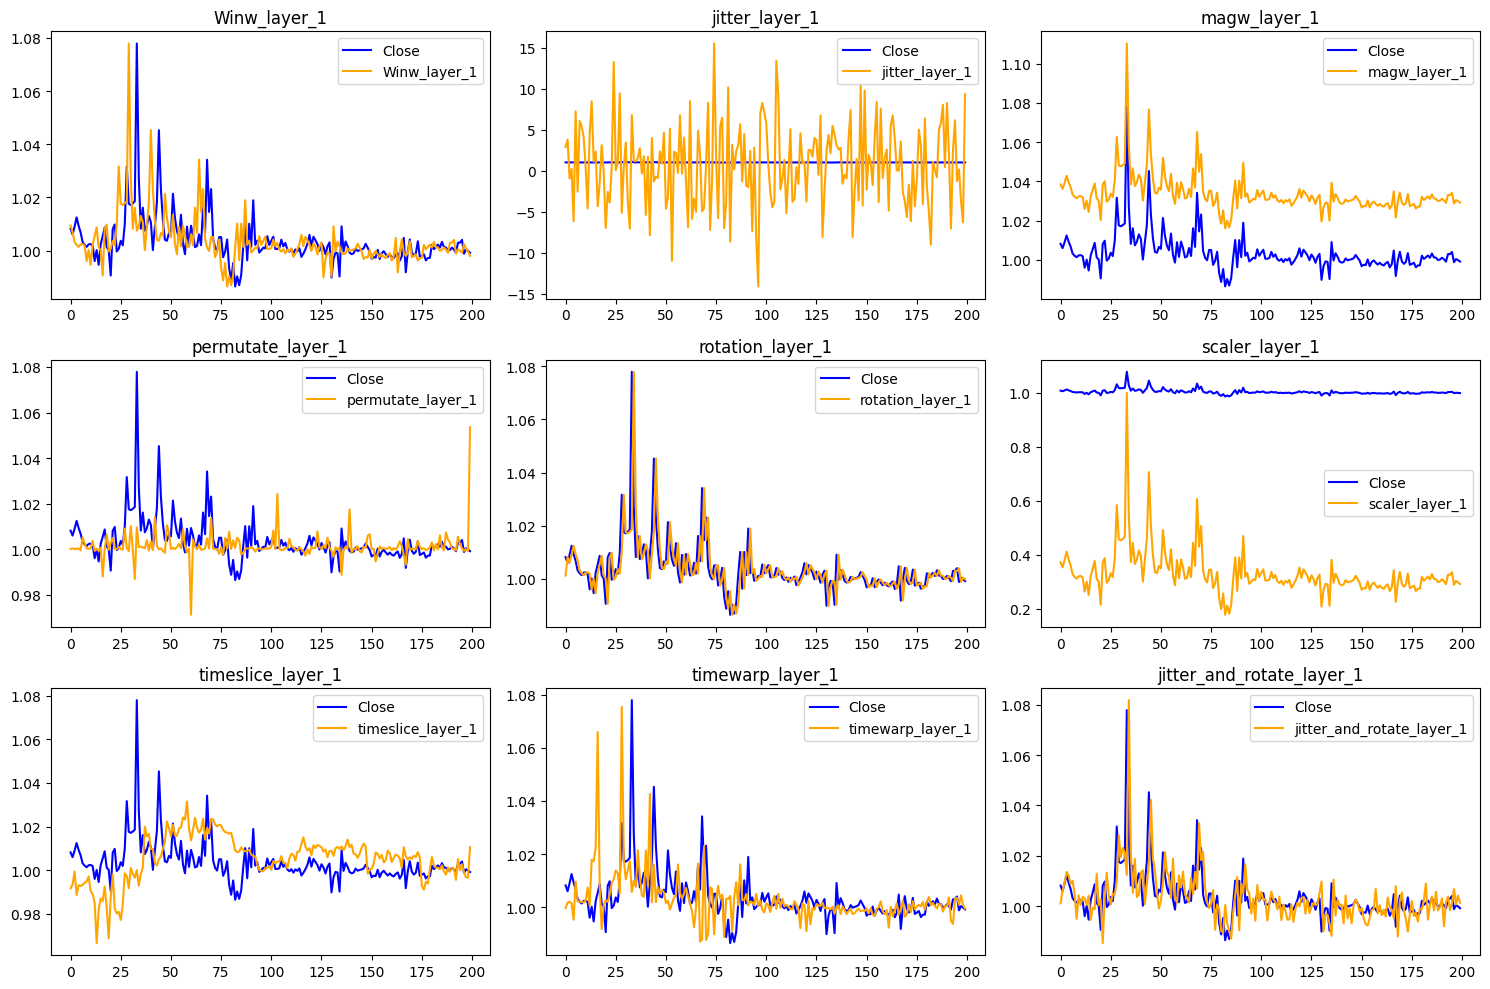

In [ ]:
paths=["/content/Winw_layer_1.csv", "/content/jitter_layer_1.csv", "/content/magw_layer_1.csv", "/content/permutate_layer_1.csv",\
 "/content/rotation_layer_1.csv", "/content/scaler_layer_1.csv", "/content/timeslice_layer_1.csv", "/content/timewarp_layer_1.csv", \
       "/content/jitter_and_rotate_layer_1.csv"]

df=data[column]
for i in paths:
  df_=pd.read_csv(i)
  col=i.split("/")[-1].split('.')[0]
  df_.columns=[col]
  df=pd.concat([df, df_], axis=1)

df=df.head(200)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each column as a subplot
for i, col in enumerate(df.columns[1:]):
    axes[i].plot(df['Close'], label='Close', color='blue')
    axes[i].plot(df[col], label=col, color='orange')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()